In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL


In [2]:
from skimage.transform import resize
import time
import numpy as np
from numpy import save
from numpy import load
import pandas as pd
import matplotlib as plt
import imutils
import dlib
import cv2
import imageio
from imutils import face_utils
from keras.utils import np_utils, generic_utils
from sklearn.utils import shuffle

In [3]:
X_train=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_train.npy')
X_val=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_val.npy')
X_test=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/X_test.npy')
y_train=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_train.npy')
y_val=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_val.npy')
y_test=load('/content/drive/My Drive/Materias/2020-2/IA_II/ProyectoFinal/Proyecto1JFCL/data/y_test.npy')

In [4]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

### Normalizacion y completamiento de los datos

In [5]:
def normalize_it(X):
  v_min = X.min(axis=(2, 3), keepdims=True)
  v_max = X.max(axis=(2, 3), keepdims=True)
  X = (X - v_min)/(v_max - v_min)
  X = np.nan_to_num(X)
  return X

In [6]:
X_train = normalize_it(X_train)
X_val = normalize_it(X_val)
X_test = normalize_it(X_test)

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
y_val = np_utils.to_categorical(y_val, 10)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [7]:
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1200, 22, 100, 100, 1)
(200, 22, 100, 100, 1)
(100, 22, 100, 100, 1)


In [8]:
print(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3],X_train.shape[4])

1200 22 100 100 1


### Modelo

In [9]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape, SimpleRNN
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt

In [10]:
#del model
#del history

In [11]:
model = Sequential()

# 1st layer group
model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

shape = model.layers[5].output_shape
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

# Gated Recurrent Unit - Recurrent Network Layer
model.add(GRU(32, return_sequences=True))
model.add(Dropout(.5))

model.add((Flatten()))

# # FC layers group
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 98, 98, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 47, 47, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 23, 23, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 21, 21, 128)    221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 10, 10, 128)    0         
_________________________________________________________________
reshape (Reshape)            (None, 128, 100)          0

In [12]:
t1 = time.time()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/120
38/38 [==============================] - 38s 172ms/step - loss: 2.3049 - accuracy: 0.0885 - val_loss: 2.3025 - val_accuracy: 0.0950
Epoch 2/120
38/38 [==============================] - 5s 141ms/step - loss: 2.3016 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/120
38/38 [==============================] - 5s 142ms/step - loss: 2.3021 - accuracy: 0.1065 - val_loss: 2.3021 - val_accuracy: 0.0950
Epoch 4/120
38/38 [==============================] - 5s 141ms/step - loss: 2.3007 - accuracy: 0.1050 - val_loss: 2.3019 - val_accuracy: 0.1050
Epoch 5/120
38/38 [==============================] - 5s 142ms/step - loss: 2.3045 - accuracy: 0.0950 - val_loss: 2.3017 - val_accuracy: 0.1050
Epoch 6/120
38/38 [==============================] - 5s 141ms/step - loss: 2.3025 - accuracy: 0.0860 - val_loss: 2.3017 - val_accuracy: 0.1000
Epoch 7/120
38/38 [==============================] - 5s 140ms/step - loss: 2.3010 - accuracy: 0.1083 - val_loss: 2.3014 - val_accuracy: 0.105

### Entremaiento y validación

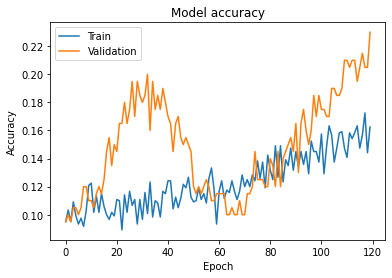

In [13]:
#@title Valores de Accuracy
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

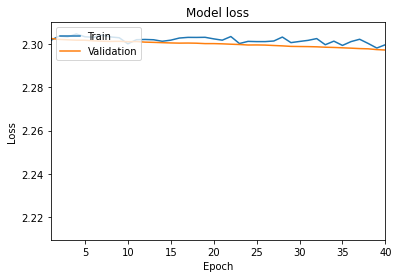

In [14]:
#@title Valores Loss
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Predicción de modelos

In [15]:
ypred = model.predict(X_test)

predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)] 

correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
#     print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy} on completely unseen data")

Accuracy = 0.18 on completely unseen data
